In [2]:
import pandas as pd
import numpy as np
import glob

import os
from scipy.interpolate import interp1d
import re

import matplotlib.pyplot as plt

In [3]:
#ForKK Local
DataPath = "./XC-CleanedData/**/*.csv"
FilteredDataPath = "./GeneratedData/"
FilteredDataPathCenterlines = "./GeneratedData/Centerlines"

In [4]:
HeaderWithoutAccel = ["ApproachRateOther", 
                      "Rel_Pos_Magnitude", 
                      "SteerB", 
                      "A_Head_Center_Distance", "B_Head_Center_Distance", 
                      "Filtered_B_Head_Velocity_Total",
                      "A_Turn",
                      "B_Indicator",
                      "Centerline_Offset_B",
                      "RelativeRotation"]

# Calculate Initial Status


In [5]:
ListOfScenarios=["CP1","CP2","CP3","CP5","CP6","CP7","CP8"]
MaxDistance=35
window_size = 5  # This can be changed depending on how much smoothing you want
kernel = np.ones(window_size) / window_size
column_types = {'ScenarioTime': 'float64',
                'AccelA': 'float64',
                'AccelB': 'float64',
                'SteerA': 'float64',
                'SteerB': 'float64',
                'HeadPosXA': 'float64',
                'HeadPosYA': 'float64',
                'HeadPosZA': 'float64',
                'HeadPosXB': 'float64',
                'HeadPosYB': 'float64',
                'HeadPosZB': 'float64',
                'HeadrotYA': 'float64',
                'HeadrotYB': 'float64',
                }

required_columns = set(column_types.keys())

# Initialize a dictionary to hold data by scenario
data_by_scenario = {}
data_by_scenario_location = {}

In [6]:
def separate_letters_numbers(s):
    match = re.match(r"([a-zA-Z]+)([0-9]+)", s)
    if match:
        letters, numbers = match.groups()
        return letters.upper(), numbers
    else:
        return s, ""

In [7]:
# Set options to avoid chained assignment warnings
pd.options.mode.chained_assignment = None

CSVFiles = glob.glob(DataPath, recursive=True)

# Read and organize data by scenario    
for val in CSVFiles:
  Scenario = os.path.basename(val).split('-')[1].split('_')[0]
  Location, Run = separate_letters_numbers(os.path.basename(val).split('-')[2].split('_')[0])
  if(Scenario in ListOfScenarios):
    try:
      df = pd.read_csv(val,sep=';',dtype=column_types)
    except Exception as e:
      print(f"An error occurred while reading {Scenario} at {Location} Run {Run}: {e}")
      continue
    is_columns = set(df.columns)
    if not required_columns.issubset(is_columns):
      missing_columns = required_columns - is_columns
      print(f"DataFrame is missing columns: {missing_columns} {Scenario} at {Location} Run {Run}")
      continue
    # Head-Center Distance
    df['A_Head_Center_Distance'] = np.sqrt(df['HeadPosXA']**2 + df['HeadPosYA']**2 + df['HeadPosZA']**2)
    df['B_Head_Center_Distance'] = np.sqrt(df['HeadPosXB']**2 + df['HeadPosYB']**2 + df['HeadPosZB']**2)
    
    # Define dataframe inner area to be within a radius of MaxDistance = 35
    innerArea = df.loc[(df['A_Head_Center_Distance'] < MaxDistance)
                        & (df['B_Head_Center_Distance'] < MaxDistance)].copy().reset_index()
    if innerArea.shape[0] == 0:
        print("Skipping: ", Scenario, Location, Run)
        continue
      
    # Entering the circle or leaving:
    innerArea['diff_A_Head_Center_Distance'] = innerArea['A_Head_Center_Distance'].diff()
    innerArea['diff_B_Head_Center_Distance'] = innerArea['B_Head_Center_Distance'].diff()
    # Timeframe reset
    innerArea['DeltaTime'] = innerArea['ScenarioTime'].diff()
    innerArea['ScenarioTime']= innerArea['ScenarioTime'] - innerArea['ScenarioTime'].iloc[0]
    # todo: turn head_delta into vector
    # Delta positions along x,y,z axis
    innerArea['A_Head_DeltaX'] = innerArea['HeadPosXA'].diff()
    innerArea['A_Head_DeltaZ'] = innerArea['HeadPosZA'].diff()
    innerArea['A_Head_DeltaY'] = innerArea['HeadPosYA'].diff()
    innerArea['B_Head_DeltaX'] = innerArea['HeadPosXB'].diff()
    innerArea['B_Head_DeltaY'] = innerArea['HeadPosYB'].diff()
    innerArea['B_Head_DeltaZ'] = innerArea['HeadPosZB'].diff()
    # Velocity along x,y,z axis
    innerArea['A_Head_VelocityX'] = innerArea['A_Head_DeltaX'] / innerArea['DeltaTime']
    innerArea['A_Head_VelocityY'] = innerArea['A_Head_DeltaY'] / innerArea['DeltaTime']
    innerArea['A_Head_VelocityZ'] = innerArea['A_Head_DeltaZ'] / innerArea['DeltaTime']
    innerArea['B_Head_VelocityX'] = innerArea['B_Head_DeltaX'] / innerArea['DeltaTime']
    innerArea['B_Head_VelocityY'] = innerArea['B_Head_DeltaY'] / innerArea['DeltaTime']
    innerArea['B_Head_VelocityZ'] = innerArea['B_Head_DeltaZ'] / innerArea['DeltaTime']
    # Set start velocity at 0
    innerArea['A_Head_VelocityX'].iloc[0] = 0#innerArea['A_Head_VelocityX'].iloc[1]
    innerArea['A_Head_VelocityY'].iloc[0] = 0#innerArea['A_Head_VelocityY'].iloc[1]
    innerArea['A_Head_VelocityZ'].iloc[0] = 0#innerArea['A_Head_VelocityZ'].iloc[1]
    innerArea['B_Head_VelocityX'].iloc[0] = 0#innerArea['B_Head_VelocityX'].iloc[1]
    innerArea['B_Head_VelocityY'].iloc[0] = 0#innerArea['B_Head_VelocityY'].iloc[1]
    innerArea['B_Head_VelocityZ'].iloc[0] = 0#innerArea['B_Head_VelocityZ'].iloc[1]
    # Smooth velocity and get total velocity
    innerArea['Filtered_A_Head_VelocityX'] = np.convolve(innerArea['A_Head_VelocityX'], kernel, 'same')
    innerArea['Filtered_A_Head_VelocityY'] = np.convolve(innerArea['A_Head_VelocityY'], kernel, 'same')
    innerArea['Filtered_A_Head_VelocityZ'] = np.convolve(innerArea['A_Head_VelocityZ'], kernel, 'same')
    innerArea['Filtered_A_Head_Velocity_Total'] = np.sqrt(innerArea['Filtered_A_Head_VelocityX']**2 
                                                        + innerArea['Filtered_A_Head_VelocityY']**2 
                                                        + innerArea['Filtered_A_Head_VelocityZ']**2)
    innerArea['Filtered_B_Head_VelocityX'] = np.convolve(innerArea['B_Head_VelocityX'], kernel, 'same')
    innerArea['Filtered_B_Head_VelocityY'] = np.convolve(innerArea['B_Head_VelocityY'], kernel, 'same')
    innerArea['Filtered_B_Head_VelocityZ'] = np.convolve(innerArea['B_Head_VelocityZ'], kernel, 'same')
    innerArea['Filtered_B_Head_Velocity_Total'] = np.sqrt(innerArea['Filtered_B_Head_VelocityX']**2 
                                                        + innerArea['Filtered_B_Head_VelocityY']**2 
                                                        + innerArea['Filtered_B_Head_VelocityZ']**2)
    # Relative velocity along x,y,z axis
    innerArea['RelVelocity_X'] = innerArea['Filtered_A_Head_VelocityX'] - innerArea['Filtered_B_Head_VelocityX']
    innerArea['RelVelocity_Y'] = innerArea['Filtered_A_Head_VelocityY'] - innerArea['Filtered_B_Head_VelocityY']
    innerArea['RelVelocity_Z'] = innerArea['Filtered_A_Head_VelocityZ'] - innerArea['Filtered_B_Head_VelocityZ']
    # Relative total velocity
    innerArea['RelVelocity'] = np.sqrt(innerArea['RelVelocity_X']**2 
                                        + innerArea['RelVelocity_Y']**2 
                                        + innerArea['RelVelocity_Z']**2)
    # Relative distance along x,y,z axis
    innerArea['Rel_Distance_X'] = innerArea['HeadPosXA'] - innerArea['HeadPosXB']
    innerArea['Rel_Distance_Y'] = innerArea['HeadPosYA'] - innerArea['HeadPosYB']
    innerArea['Rel_Distance_Z'] = innerArea['HeadPosZA'] - innerArea['HeadPosZB']
    # Relative position distance
    innerArea['Rel_Pos_Magnitude'] = np.sqrt(innerArea['Rel_Distance_X']**2 
                                            + innerArea['Rel_Distance_Y']**2 
                                            + innerArea['Rel_Distance_Z']**2)
    # Measures the component of the relative velocity that is in the direction of the relative distance
    innerArea['Dot_Product'] = (innerArea['Rel_Distance_X'] * innerArea['RelVelocity_X'] 
                                + innerArea['Rel_Distance_Y'] * innerArea['RelVelocity_Y'] 
                                + innerArea['Rel_Distance_Z'] * innerArea['RelVelocity_Z'])
    # Normalizes this measure by the distance, 
    # providing a rate at which the two entities are closing in on each other
    innerArea['ApproachRate'] = innerArea['Dot_Product'] / innerArea['Rel_Pos_Magnitude']
    # Measures the component of the smoothed relative velocity that is in the direction of the relative distance
    innerArea['Dot_Product_Other'] = (innerArea['Rel_Distance_X'] * innerArea['Filtered_B_Head_VelocityX'] 
                                    + innerArea['Rel_Distance_Y'] * innerArea['Filtered_B_Head_VelocityY'] 
                                    + innerArea['Rel_Distance_Z'] * innerArea['Filtered_B_Head_VelocityZ'])
    # providing a rate at which the two entities are closing in on each other after smoothing
    innerArea['ApproachRateOther'] = innerArea['Dot_Product_Other'] / innerArea['Rel_Pos_Magnitude']
    
    # Append data to the corresponding scenario
    if Scenario not in data_by_scenario:
      data_by_scenario[Scenario] = []
    data_by_scenario[Scenario].append(innerArea)
    # Append data to the corresponding scenario and location
    if Scenario not in data_by_scenario_location:
        data_by_scenario_location[Scenario] = {}
    if Location not in data_by_scenario_location[Scenario]:
        data_by_scenario_location[Scenario][Location] = []
    data_by_scenario_location[Scenario][Location].append(innerArea)

Skipping:  CP5 NYC 1
Skipping:  CP2 NYC 1
Skipping:  CP1 NYC 1
Skipping:  CP1 NYC 25
Skipping:  CP1 ISR 13
Skipping:  CP1 NYC 9
Skipping:  CP5 ISR 39
Skipping:  CP5 ISR 38
Skipping:  CP2 ISR 38
Skipping:  CP3 NYC 2
Skipping:  CP2 NYC 10
Skipping:  CP6 ISR 11
DataFrame is missing columns: {'HeadPosYA', 'AccelB', 'HeadPosXA', 'HeadPosZB', 'HeadPosXB', 'AccelA', 'HeadrotYA', 'ScenarioTime', 'SteerA', 'SteerB', 'HeadrotYB', 'HeadPosZA', 'HeadPosYB'} CP1 at NYC Run 42
Skipping:  CP3 NYC 11
Skipping:  CP7 NYC 16
Skipping:  CP7 NYC 29
Skipping:  CP5 NYC 3
Skipping:  CP3 NYC 4
Skipping:  CP5 ITH 3
Skipping:  CP1 NYC 34
Skipping:  CP1 NYC 34
An error occurred while reading CP1 at NYC Run 34: could not convert string to float: ''
An error occurred while reading CP7 at NYC Run 33: could not convert string to float: ''
An error occurred while reading CP2 at NYC Run 33: could not convert string to float: ''
Skipping:  CP6 NYC 14
Skipping:  CP6 ISR 34
Skipping:  CP5 ISR 03


In [8]:
# Filter the DataFrame for the desired range
df = innerArea[(innerArea['A_Head_Center_Distance'] <= 35) & (innerArea['A_Head_Center_Distance'] > 30)]

# Check for continuous decreasing sequence
continuous_decreasing_indices = []
previous_index = df.index[0]  # Start with the first index

for idx in df.index:
    # Check if current index is the next in sequence and the value is decreasing
    if (idx == previous_index + 1) and (df.loc[idx, 'diff_A_Head_Center_Distance'] < 0):
        continuous_decreasing_indices.append(idx)
    else:
        # If the index is not the next one, check if it's because of the new series (e.g., jump from 30 to 518)
        if idx > previous_index + 1:
            break  # Break if there's a large gap, indicating a new series
    previous_index = idx

# Include the first element manually if it starts the series
if continuous_decreasing_indices:
    continuous_decreasing_indices.insert(0, df.index[0])

# Filter DataFrame to include only the first continuous decreasing series
df_first_continuous_decreasing = df.loc[continuous_decreasing_indices]


df_first_continuous_decreasing

,index,AccelA,AccelB,ButtonA,ButtonB,Car PositionXA,Car PositionXB,Car PositionYA,Car PositionYB,Car PositionZA,...,RelVelocity_Z,RelVelocity,Rel_Distance_X,Rel_Distance_Y,Rel_Distance_Z,Rel_Pos_Magnitude,Dot_Product,ApproachRate,Dot_Product_Other,ApproachRateOther
0,878,0.2218,0.4100,False,False,1.2660,1.2660,-0.0386,-0.0386,-34.9042,...,1.450317,1.453186,1.2093,0.0688,-64.1747,64.186130,-92.963735,-1.448346,54.181020,0.844123
1,879,0.2268,0.4111,False,False,1.2549,1.2549,-0.0387,-0.0387,-34.7907,...,2.260631,2.265018,1.2264,0.0680,-63.9059,63.917703,-144.295593,-2.257522,84.208594,1.317453
2,880,0.2316,0.4116,False,False,1.2446,1.2446,-0.0388,-0.0388,-34.6770,...,3.044438,3.050405,1.2428,0.0671,-63.6417,63.653869,-193.517242,-3.040149,113.035183,1.775779
3,881,0.2468,0.4121,False,False,1.2341,1.2341,-0.0390,-0.0390,-34.5511,...,3.844152,3.851822,1.2625,0.0661,-63.3196,63.332219,-243.104792,-3.838564,142.079899,2.243406
4,882,0.2677,0.4123,False,False,1.2257,1.2257,-0.0391,-0.0391,-34.4383,...,3.817552,3.825295,1.2800,0.0650,-63.0437,63.056726,-240.362756,-3.811850,140.648199,2.230503
5,883,0.2863,0.4121,False,False,1.2180,1.2180,-0.0393,-0.0393,-34.3243,...,3.770753,3.778515,1.2982,0.0638,-62.7646,62.778057,-236.357148,-3.764964,138.360943,2.203970
6,884,0.3063,0.4058,False,False,1.2089,1.2089,-0.0395,-0.0395,-34.1773,...,3.937915,3.946077,1.3187,0.0624,-62.4557,62.469651,-245.612562,-3.931710,143.711709,2.300504
7,885,0.3198,0.4003,False,False,1.2006,1.2006,-0.0397,-0.0397,-34.0290,...,3.832214,3.839974,1.3375,0.0611,-62.1645,62.178917,-237.903246,-3.826108,139.054551,2.236362
8,886,0.3348,0.3959,False,False,1.1940,1.1940,-0.0399,-0.0399,-33.9000,...,4.142601,4.150361,1.3600,0.0594,-61.8043,61.819290,-255.687653,-4.136050,149.117661,2.412154
9,887,0.3477,0.3930,False,False,1.1868,1.1868,-0.0401,-0.0401,-33.7472,...,4.442681,4.450296,1.3769,0.0581,-61.5178,61.533234,-272.947986,-4.435782,158.755619,2.579998


In [9]:
df.columns

Index(['index', 'AccelA', 'AccelB', 'ButtonA', 'ButtonB', 'Car PositionXA',
       'Car PositionXB', 'Car PositionYA', 'Car PositionYB', 'Car PositionZA',
       'Car PositionZB', 'Car RotationXA', 'Car RotationXB', 'Car RotationYA',
       'Car RotationYB', 'Car RotationZA', 'Car RotationZB', 'Car VelocityXB',
       'Car VelocityYA', 'Car VelocityYB', 'Car VelocityZA', 'Car VelocityZB',
       'CarVelocityXA', 'Frame Number', 'FrameRate', 'GameTime', 'HeadPosXA',
       'HeadPosXB', 'HeadPosYA', 'HeadPosYB', 'HeadPosZA', 'HeadPosZB',
       'HeadrotXA', 'HeadrotXB', 'HeadrotYA', 'HeadrotYB', 'HeadrotZA',
       'HeadrotZB', 'IndicatorsA', 'IndicatorsB', 'LeftHandA', 'LeftHandB',
       'RightHandA', 'RightHandB', 'ScenarioTime', 'SteerA', 'SteerB',
       'A_Head_Center_Distance', 'B_Head_Center_Distance',
       'diff_A_Head_Center_Distance', 'diff_B_Head_Center_Distance',
       'DeltaTime', 'A_Head_DeltaX', 'A_Head_DeltaZ', 'A_Head_DeltaY',
       'B_Head_DeltaX', 'B_Head_DeltaY',

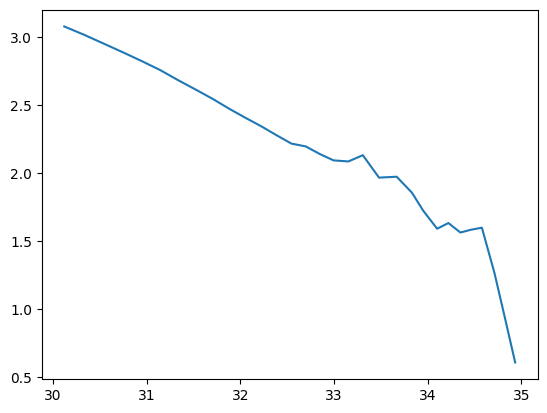

In [10]:
plt.plot(df_first_continuous_decreasing['A_Head_Center_Distance'], df_first_continuous_decreasing['Filtered_A_Head_Velocity_Total'])

In [11]:
df_series.columns

NameError: name 'df_series' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


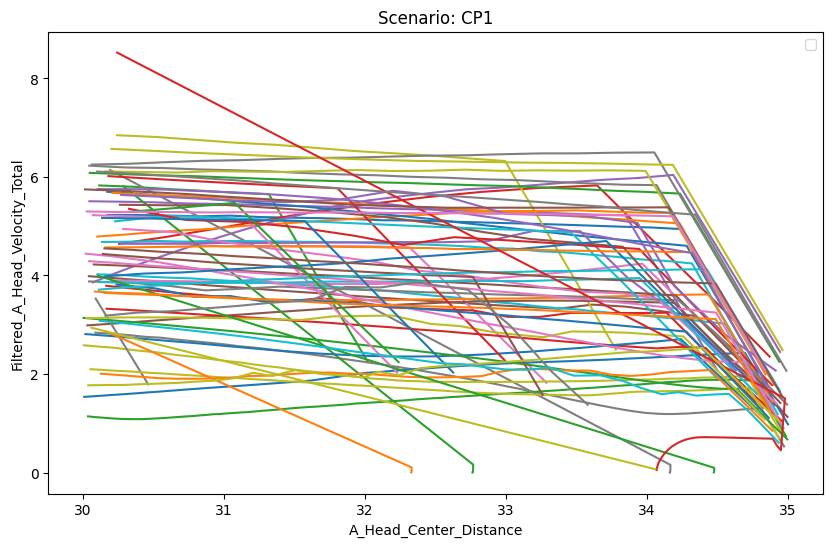

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


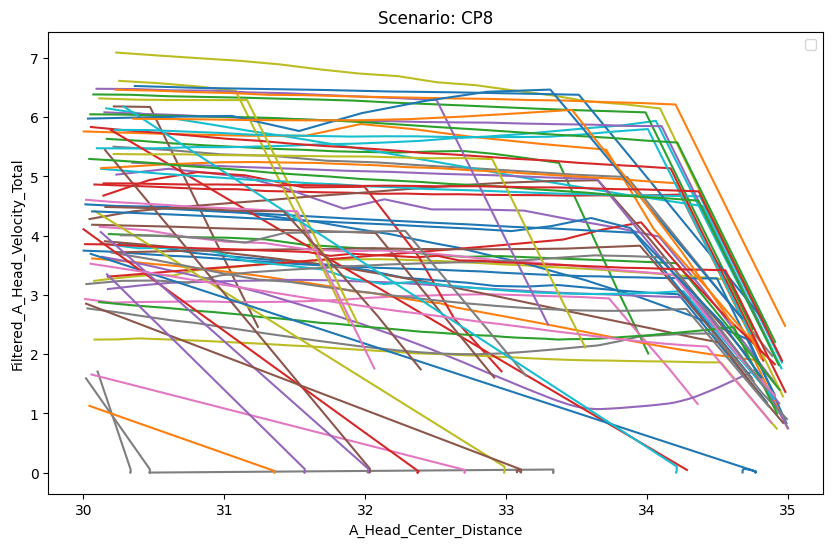

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


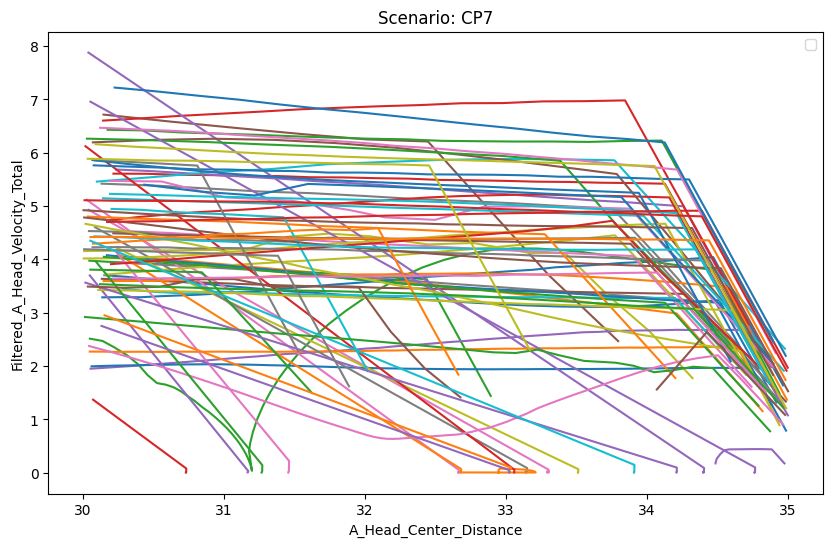

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


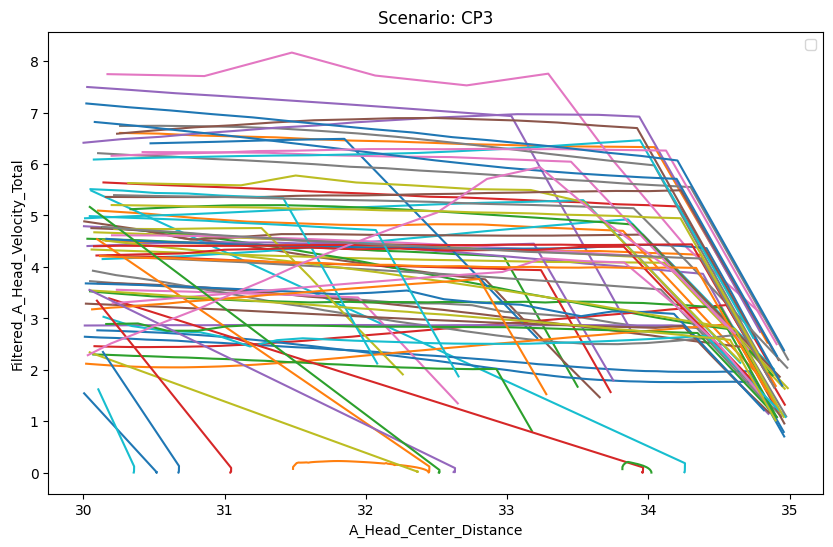

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


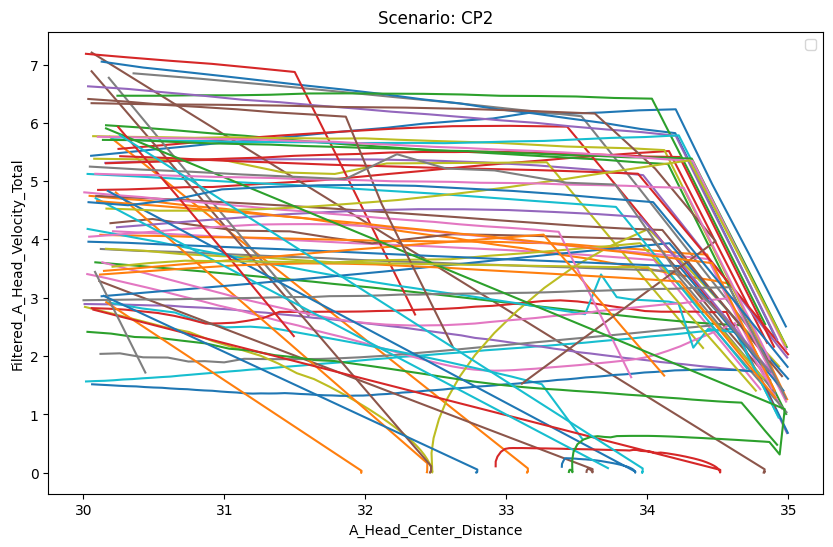

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


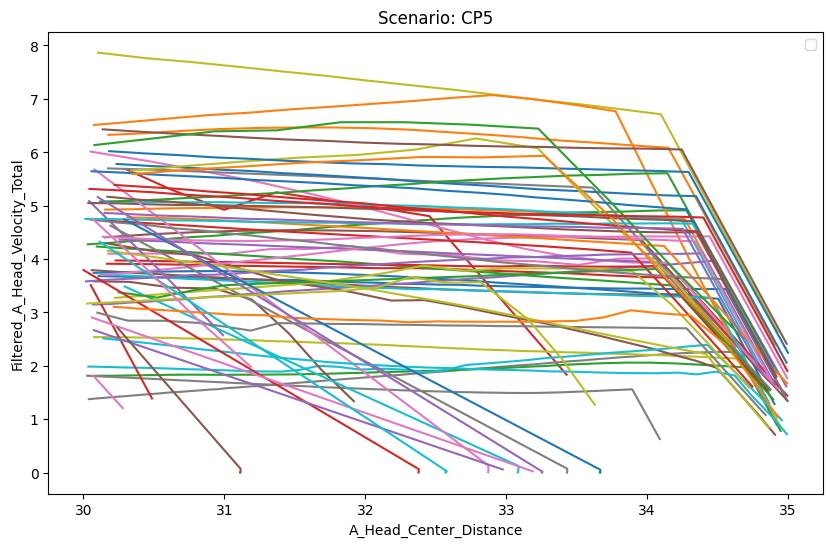

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


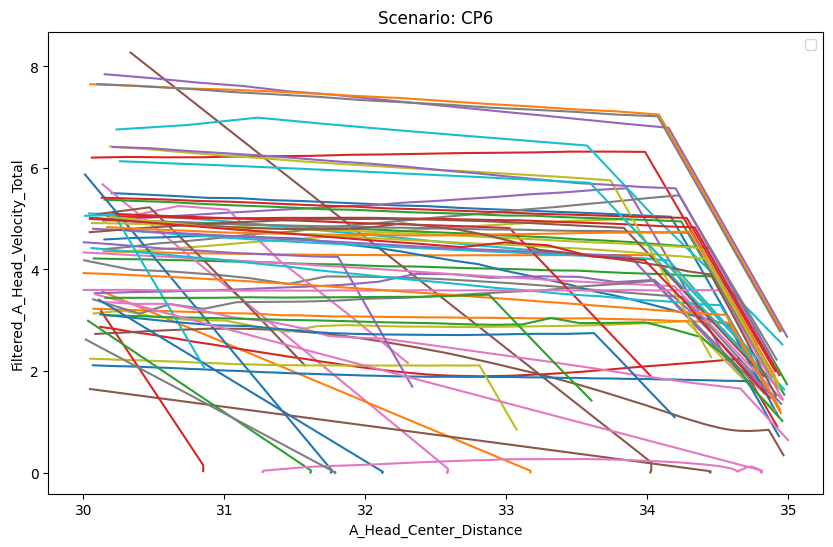

In [13]:
# Loop through each scenario
for scenario, areas in data_by_scenario.items():
    # Create a new figure for each scenario
    plt.figure(figsize=(10, 6))
    plt.title(f'Scenario: {scenario}')
    plt.xlabel('A_Head_Center_Distance')
    plt.ylabel('Filtered_A_Head_Velocity_Total')
    
    # Plot each run in the scenario
    for innerArea in areas:
        # Filter the DataFrame for the first continuous decreasing series within the specified distance range
        df_filtered = innerArea[(innerArea['A_Head_Center_Distance'] <= 35) & 
                                (innerArea['A_Head_Center_Distance'] > 30)]
        
        # Find the first continuous decreasing sequence
        continuous_decreasing_indices = []
        
        if df_filtered.shape[0] > 0:
            previous_index = df_filtered.index[0]

            for idx in df_filtered.index:
                if (idx == previous_index + 1) and (df_filtered.loc[idx, 'A_Head_Center_Distance'] < df_filtered.loc[previous_index, 'A_Head_Center_Distance']):
                    continuous_decreasing_indices.append(idx)
                else:
                    if idx > previous_index + 1:
                        break  # Stop if a new series is detected
                previous_index = idx

            if continuous_decreasing_indices:
                continuous_decreasing_indices.insert(0, df_filtered.index[0])

            df_series = df_filtered.loc[continuous_decreasing_indices]
            
            plt.plot(df_series['A_Head_Center_Distance'], df_series['Filtered_A_Head_Velocity_Total'])

    plt.legend()
    plt.show()


# Testing inputs for car A

# centerline things


In [9]:
# Functions for centerline

# Function to resample a path to a fixed number of points
def resample_path(df, car='A', num_points=400):
    col_x = 'HeadPosX' + car
    col_y = 'HeadPosZ' + car
    if col_x not in df.columns or col_y not in df.columns:
        raise KeyError(f"Columns '{col_x}' and '{col_y}' are required in the DataFrame")
    
    # Calculate the cumulative distance along the path
    distances = np.sqrt(np.diff(df[col_x])**2 + np.diff(df[col_y])**2)
    cumulative_distances = np.insert(np.cumsum(distances), 0, 0)
    
    # Interpolation functions for X and Y coordinates
    interp_func_x = interp1d(cumulative_distances, df[col_x], kind='linear')
    interp_func_y = interp1d(cumulative_distances, df[col_y], kind='linear')
    
    # New distance values for resampling
    new_distances = np.linspace(0, cumulative_distances[-1], num=num_points)
    
    # Interpolated X and Y coordinates
    resampled_x = interp_func_x(new_distances)
    resampled_y = interp_func_y(new_distances)
    
    return pd.DataFrame({col_x: resampled_x, col_y: resampled_y})
    
# Function to compute the median start and end points
def compute_median_start_end(paths, col_x, col_y):
    start_points = pd.DataFrame({col_x: [path[col_x].iloc[0] for path in paths], 
                                 col_y: [path[col_y].iloc[0] for path in paths]})
    end_points = pd.DataFrame({col_x: [path[col_x].iloc[-1] for path in paths], 
                               col_y: [path[col_y].iloc[-1] for path in paths]})
    median_start = start_points.median()
    median_end = end_points.median()
    return median_start, median_end    

# Function to detect outliers based on start and end points
def detect_outliers_by_start_end(paths, median_start, median_end, col_x, col_y, threshold):
    cleaned_paths = []
    for path in paths:
        start_distance = np.sqrt((path[col_x].iloc[0] - median_start[col_x])**2 + (path[col_y].iloc[0] - median_start[col_y])**2)
        end_distance = np.sqrt((path[col_x].iloc[-1] - median_end[col_x])**2 + (path[col_y].iloc[-1] - median_end[col_y])**2)
        if start_distance <= threshold and end_distance <= threshold:
            cleaned_paths.append(path)
    return cleaned_paths

## By Scenarios and Locations

In [10]:
# Resample paths for each scenario and location
resampled_data_by_scenario_location_A = {}
resampled_data_by_scenario_location_B = {}

for scenario, locations in data_by_scenario_location.items():
    resampled_data_by_scenario_location_A[scenario] = {}
    resampled_data_by_scenario_location_B[scenario] = {}
    for location, runs in locations.items():
        resampled_runs_A = [resample_path(run, car='A') for run in runs]
        resampled_runs_B = [resample_path(run, car='B') for run in runs]
        resampled_data_by_scenario_location_A[scenario][location] = resampled_runs_A
        resampled_data_by_scenario_location_B[scenario][location] = resampled_runs_B

# Remove outliers for each scenario and location
cleaned_data_by_scenario_location_A = {}
cleaned_data_by_scenario_location_B = {}

threshold = 10

for scenario, locations in resampled_data_by_scenario_location_A.items():
    cleaned_data_by_scenario_location_A[scenario] = {}
    cleaned_data_by_scenario_location_B[scenario] = {}
    for location, resampled_runs_A in locations.items():
        resampled_runs_B = resampled_data_by_scenario_location_B[scenario][location]
        median_start_A, median_end_A = compute_median_start_end(resampled_runs_A, 'HeadPosXA', 'HeadPosZA')
        median_start_B, median_end_B = compute_median_start_end(resampled_runs_B, 'HeadPosXB', 'HeadPosZB')
        cleaned_paths_A = detect_outliers_by_start_end(resampled_runs_A, median_start_A, median_end_A, 'HeadPosXA', 'HeadPosZA', threshold)
        cleaned_paths_B = detect_outliers_by_start_end(resampled_runs_B, median_start_B, median_end_B, 'HeadPosXB', 'HeadPosZB', threshold)
        cleaned_data_by_scenario_location_A[scenario][location] = cleaned_paths_A
        cleaned_data_by_scenario_location_B[scenario][location] = cleaned_paths_B

# Compute the centerline for each scenario and location after removing outliers
centerlines_A = {}
centerlines_B = {}

for scenario, locations in cleaned_data_by_scenario_location_A.items():
    centerlines_A[scenario] = {}
    centerlines_B[scenario] = {}
    for location, cleaned_runs_A in locations.items():
        combined_resampled_A = pd.concat(cleaned_runs_A, keys=range(len(cleaned_runs_A)), names=['Run_ID', 'Point_ID'])
        average_path_A = combined_resampled_A.groupby('Point_ID').median().reset_index()
        centerlines_A[scenario][location] = average_path_A

for scenario, locations in cleaned_data_by_scenario_location_B.items():
    for location, cleaned_runs_B in locations.items():
        combined_resampled_B = pd.concat(cleaned_runs_B, keys=range(len(cleaned_runs_B)), names=['Run_ID', 'Point_ID'])
        average_path_B = combined_resampled_B.groupby('Point_ID').median().reset_index()
        centerlines_B[scenario][location] = average_path_B

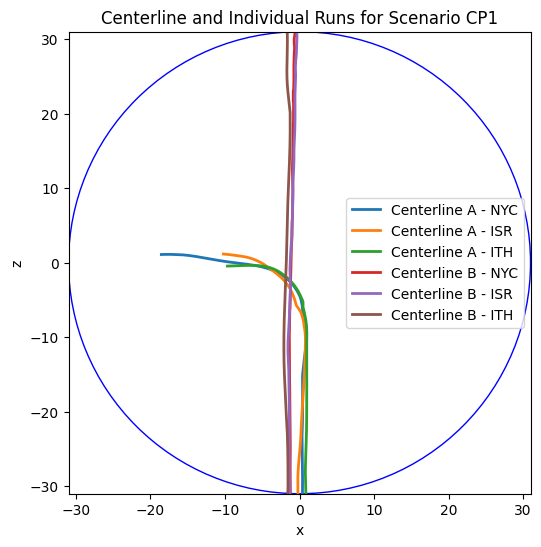

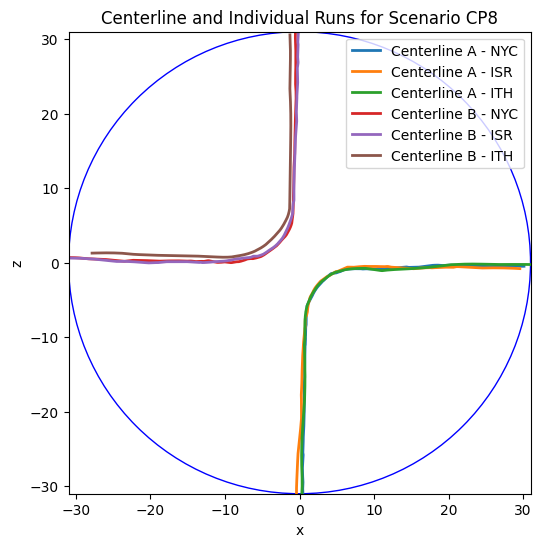

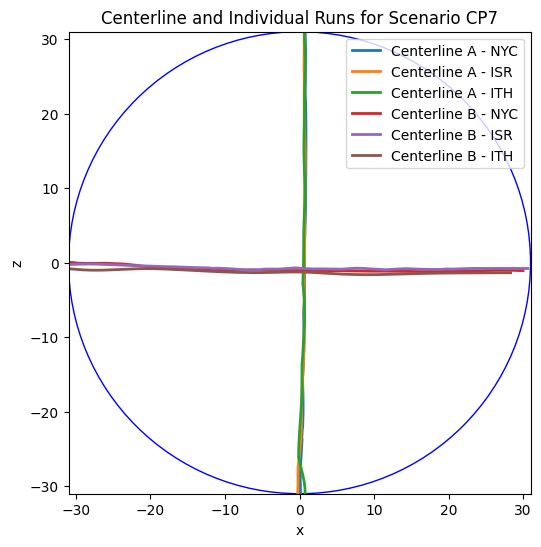

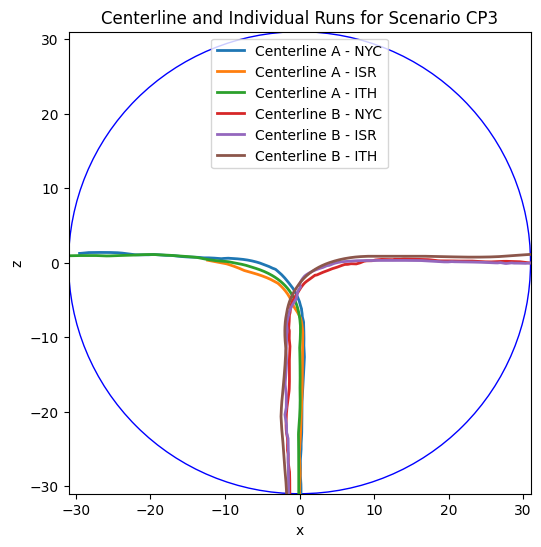

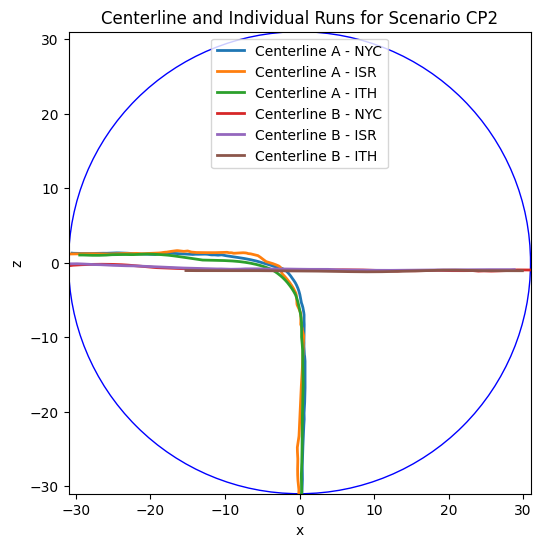

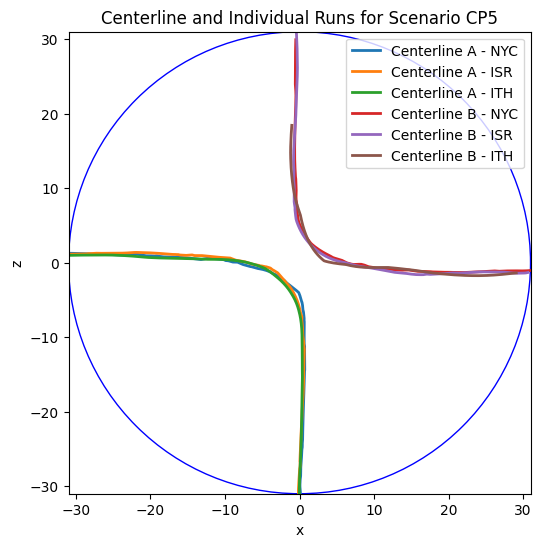

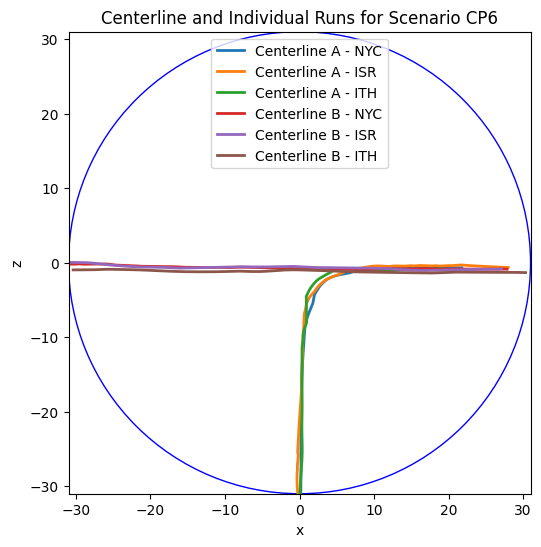

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Define the maximum distance for the circle
MaxDistance = 31

# Plot the centerline and individual paths for each scenario and location
for scenario in centerlines_A.keys():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # # Plot individual runs for car A
    # for location, runs in cleaned_data_by_scenario_location_A[scenario].items():
    #     for run in runs:
            # plt.plot(run['HeadPosXA'], run['HeadPosZA'], alpha=0.3)#, label='Individual Run A')

    # # Plot individual runs for car B
    # for location, runs in cleaned_data_by_scenario_location_B[scenario].items():
    #     for run in runs:
    #         plt.plot(run['HeadPosXB'], run['HeadPosZB'], alpha=0.3)#, label='Individual Run B')
    
    # Plot the centerline for car A by location
    for location, centerline in centerlines_A[scenario].items():
        plt.plot(centerline['HeadPosXA'], centerline['HeadPosZA'], linewidth=2, label=f'Centerline A - {location}')
    
    # Plot the centerline for car B by location
    for location, centerline in centerlines_B[scenario].items():
        plt.plot(centerline['HeadPosXB'], centerline['HeadPosZB'], linewidth=2, label=f'Centerline B - {location}')
    
    # Set limits and add the circle
    ax.set_xlim(-31, 31)
    ax.set_ylim(-31, 31)
    ax.set_aspect('equal', adjustable='box')
    circle = Circle((0, 0), MaxDistance, color='blue', fill=False)  # Center at (0,0)
    ax.add_patch(circle)

    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(f'Centerline and Individual Runs for Scenario {scenario}')
    plt.legend()
    plt.show()


## By Scenarios only

In [12]:
# Resample paths for each scenario
resampled_data_by_scenario_A = {}
resampled_data_by_scenario_B = {}

for scenario, runs in data_by_scenario.items():
    resampled_runs_A = [resample_path(run,car='A') for run in runs]
    resampled_runs_B = [resample_path(run,car='B') for run in runs]
    resampled_data_by_scenario_A[scenario] = resampled_runs_A
    resampled_data_by_scenario_B[scenario] = resampled_runs_B

# Display the resampled data structure
print(resampled_data_by_scenario_A.keys())

# Remove outliers for each scenario
cleaned_data_by_scenario_A = {}
cleaned_data_by_scenario_B = {}

threshold = 10

for scenario in resampled_data_by_scenario_A.keys():
    median_start_A, median_end_A = compute_median_start_end(resampled_data_by_scenario_A[scenario], 'HeadPosXA', 'HeadPosZA')
    median_start_B, median_end_B = compute_median_start_end(resampled_data_by_scenario_B[scenario], 'HeadPosXB', 'HeadPosZB')
    cleaned_paths_A = detect_outliers_by_start_end(resampled_data_by_scenario_A[scenario], median_start_A, median_end_A, 'HeadPosXA', 'HeadPosZA', threshold)
    cleaned_paths_B = detect_outliers_by_start_end(resampled_data_by_scenario_B[scenario], median_start_B, median_end_B, 'HeadPosXB', 'HeadPosZB', threshold)
    cleaned_data_by_scenario_A[scenario] = cleaned_paths_A
    cleaned_data_by_scenario_B[scenario] = cleaned_paths_B
    
# Compute the centerline for each scenario and each car after removing outliers
centerlines_A = {}
centerlines_B = {}

for scenario, cleaned_runs_A in cleaned_data_by_scenario_A.items():
    combined_resampled_A = pd.concat(cleaned_runs_A, keys=range(len(cleaned_runs_A)), names=['Run_ID', 'Point_ID'])
    average_path_A = combined_resampled_A.groupby('Point_ID').median().reset_index()
    centerlines_A[scenario] = average_path_A

for scenario, cleaned_runs_B in cleaned_data_by_scenario_B.items():
    combined_resampled_B = pd.concat(cleaned_runs_B, keys=range(len(cleaned_runs_B)), names=['Run_ID', 'Point_ID'])
    average_path_B = combined_resampled_B.groupby('Point_ID').median().reset_index()
    centerlines_B[scenario] = average_path_B

dict_keys(['CP1', 'CP8', 'CP7', 'CP3', 'CP2', 'CP5', 'CP6'])


In [13]:
def save_centerlines(centerlines, scenario, car_type):
    # Create the full path for the file
    file_path = os.path.join(FilteredDataPathCenterlines, f'centerline_{scenario}_{car_type}.feather')
    
    # Save the DataFrame to a Feather file
    centerlines.to_feather(file_path)
    print(f"Saved centerline for {scenario} ({car_type}) to {file_path}")

# Save centerlines for car A
for scenario, centerline_df in centerlines_A.items():
    save_centerlines(centerline_df, scenario, 'A')

# Save centerlines for car B
for scenario, centerline_df in centerlines_B.items():
    save_centerlines(centerline_df, scenario, 'B')

Saved centerline for CP1 (A) to ./GeneratedData/Centerlines/centerline_CP1_A.feather
Saved centerline for CP8 (A) to ./GeneratedData/Centerlines/centerline_CP8_A.feather
Saved centerline for CP7 (A) to ./GeneratedData/Centerlines/centerline_CP7_A.feather
Saved centerline for CP3 (A) to ./GeneratedData/Centerlines/centerline_CP3_A.feather
Saved centerline for CP2 (A) to ./GeneratedData/Centerlines/centerline_CP2_A.feather
Saved centerline for CP5 (A) to ./GeneratedData/Centerlines/centerline_CP5_A.feather
Saved centerline for CP6 (A) to ./GeneratedData/Centerlines/centerline_CP6_A.feather
Saved centerline for CP1 (B) to ./GeneratedData/Centerlines/centerline_CP1_B.feather
Saved centerline for CP8 (B) to ./GeneratedData/Centerlines/centerline_CP8_B.feather
Saved centerline for CP7 (B) to ./GeneratedData/Centerlines/centerline_CP7_B.feather
Saved centerline for CP3 (B) to ./GeneratedData/Centerlines/centerline_CP3_B.feather
Saved centerline for CP2 (B) to ./GeneratedData/Centerlines/cente

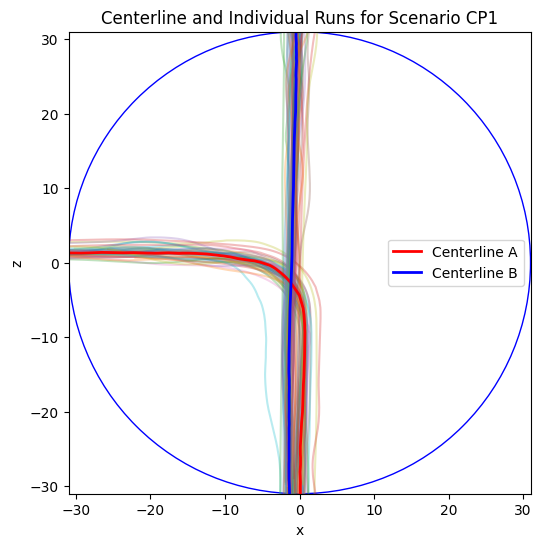

CP1: 42 Runs for A, 64 Runs for B


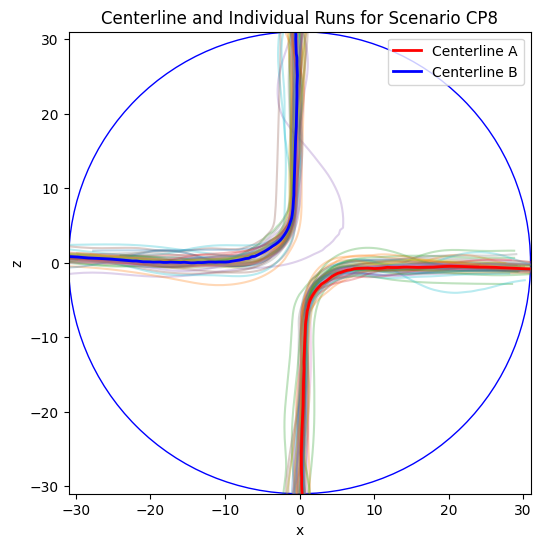

CP8: 54 Runs for A, 55 Runs for B


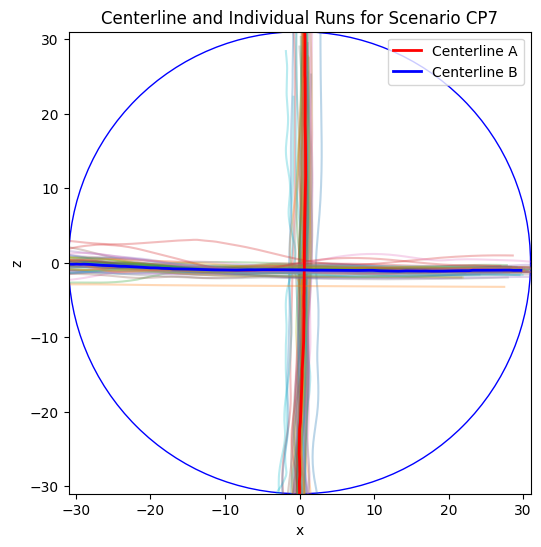

CP7: 62 Runs for A, 55 Runs for B


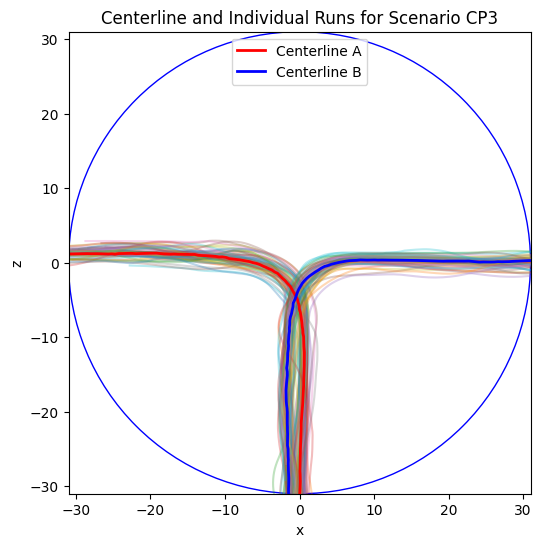

CP3: 61 Runs for A, 49 Runs for B


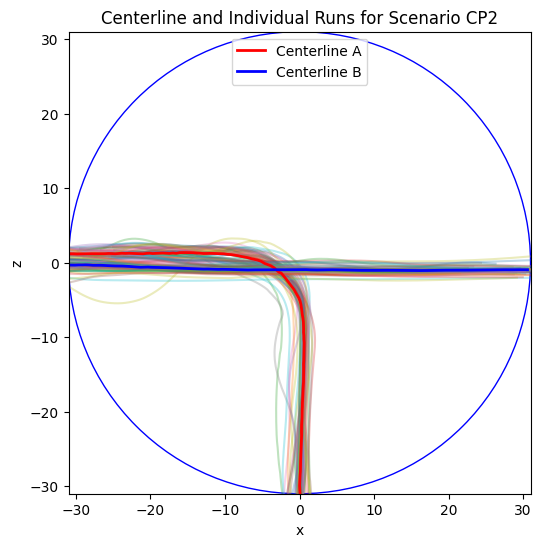

CP2: 51 Runs for A, 62 Runs for B


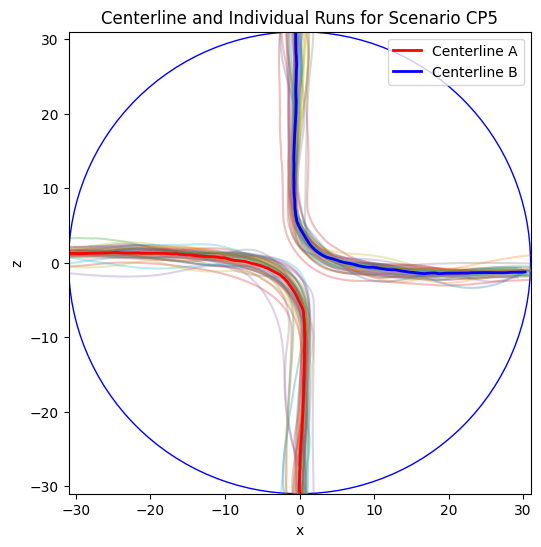

CP5: 49 Runs for A, 46 Runs for B


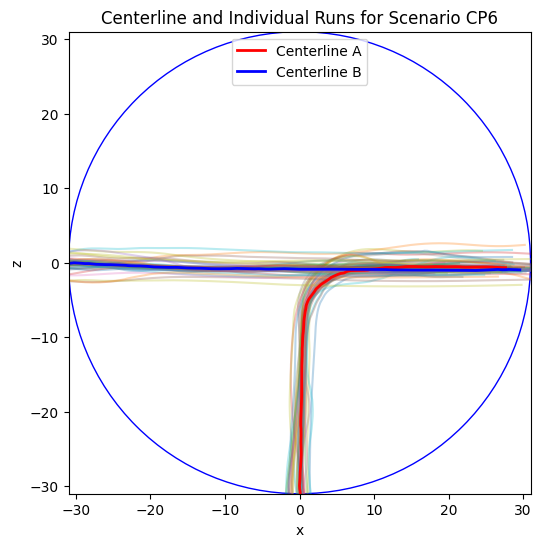

CP6: 40 Runs for A, 45 Runs for B


In [14]:
# Define the maximum distance for the circle
MaxDistance = 31

# Plot the centerline and individual paths for each scenario
for scenario in centerlines_A.keys():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot individual runs for car A
    counter_A = 0
    for run in cleaned_data_by_scenario_A[scenario]:
        counter_A += 1
        plt.plot(run['HeadPosXA'], run['HeadPosZA'], alpha=0.3)#, label='Individual Run A')

    # Plot individual runs for car B
    counter_B = 0
    for run in cleaned_data_by_scenario_B[scenario]:
        counter_B += 1
        plt.plot(run['HeadPosXB'], run['HeadPosZB'], alpha=0.3)#, label='Individual Run B')
    
    # Plot the centerline for car A
    plt.plot(centerlines_A[scenario]['HeadPosXA'], centerlines_A[scenario]['HeadPosZA'], color='red', linewidth=2, label='Centerline A')
    
    # Plot the centerline for car B
    plt.plot(centerlines_B[scenario]['HeadPosXB'], centerlines_B[scenario]['HeadPosZB'], color='blue', linewidth=2, label='Centerline B')
    
    # Set limits and add the circle
    ax.set_xlim(-31, 31)
    ax.set_ylim(-31, 31)
    ax.set_aspect('equal', adjustable='box')
    circle = Circle((0, 0), MaxDistance, color='blue', fill=False)  # Center at (0,0)
    ax.add_patch(circle)

    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(f'Centerline and Individual Runs for Scenario {scenario}')
    plt.legend()
    plt.show()
    print(f"{scenario}: {counter_A} Runs for A, {counter_B} Runs for B")

In [15]:
centerlines_A['CP1']

,Point_ID,HeadPosXA,HeadPosZA
0,0,80.731100,-75.542950
1,1,80.255503,-75.543001
2,2,79.783410,-75.548173
3,3,79.314733,-75.556924
4,4,78.840176,-75.560793
...,...,...,...
395,395,-32.133647,1.287220
396,396,-32.604043,1.305303
397,397,-33.074446,1.310835
398,398,-33.544851,1.307115
